In [10]:
#necessary modules
from matplotlib import pyplot as plt
from pandas import DataFrame as DF
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR
register_matplotlib_converters()

In [11]:
%matplotlib inline

In [15]:
#Granger Causality function-çalışıyor
#The row are the response (y) and the columns are the predictor series (x).
def grangerCausality(data,variables,test='ssr_chi2test',verbose=False,lag=10):
    x_train=DF(np.zeros((len(variables),len(variables))),
               columns=variables,index=variables)
    for c in x_train.columns:
        for r in x_train.index:
            test_result=grangercausalitytests(data[[r,c]],maxlag=lag,verbose=False)
            p_values=[round(test_result[i+1][0][test][1],4) for i in range (lag)]
            if verbose:
                print(f'Y={r},X={c},P-values={p_values}')
            min_p_values=np.min(p_values)
    x_train.columns=[var+'_x' for var in variables]
    x_train.index=[var+'y' for var in variables]
    return x_train          
    

In [16]:
#Cointegration:Johansen Test-Çalışıyor
def cointegrationTest(data,alpha=0.05):
    out=coint_johansen(data,-1,5)
    d={'0.90': 0 , '0.95' :1, '0.99' :2}
    traces=out.lr1
    cvts=out.cvt[:,d[str(1-alpha)]]
    def adjust(val,length=6): return str(val).ljust(length)
    print('Name :: Test Stat > C(95%) => Signif \n','--'*20)
    for col,trace,cvt in zip(data.columns,traces,cvts):
        print(adjust(col),'::',adjust(round(trace,2),9),">",
             adjust(cvt,8),"=>", trace>cvt)

In [17]:
#Variational Model-Çalışıyor
def varModel(data,maxLag=15):
    mod=smt.VAR(data)
    res=mod.fit(maxlags=maxLag,ic='aic')
    print(res.summary())

In [48]:
#ADFuller Test
def adfuller_test(data,signif=0.05,name='',verbose=False):
    r=adfuller(data,autolag='AIC')
    output={'test_statistics': round(r[0],4),'pvalue':round(r[1],4),'n_lags':round(r[2],4),
           'n_obs':r[3]}
    p_value=output['pvalue']
    def adjust(val,length=6): return str(val).ljust(length)
    
    for key,val in r[4].items():
        print(f'Critical value{adjust(key,6)}={round(val,3)}')
    
    if p_value<=signif:
        print(f'=> P-Value={p_value}.Rejecting Null Hypothesis.')
        print(f'=> Series is Stationary.')
    else:
        print(f'=> P-Value={p_value}.Weak evidence to reject the Null Hypothesis')

def adfForAll(data):
    for name, column in data.iteritems():
        adfuller_test(column,name=column.name)
        print('\n')

In [19]:
#Durbin-Watson Statistic-Çalısıyor
def DW(data,lags=15):
    mod=smt.VAR(data)
    res=mod.fit(maxlags=lags,ic='aic')
    out=durbin_watson(res.resid)
    for col,val in zip(data.columns,out):
        print((col),':',round(val,2))

In [20]:
#ExampleDataSet
data=pd.read_csv('gld_price_data.csv',index_col='Date')
data.describe()

,SPX,GLD,USO,SLV,EUR/USD
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,1654.315776,122.732875,31.842221,20.084997,1.283653
std,519.111540,23.283346,19.523517,7.092566,0.131547
min,676.530029,70.000000,7.960000,8.850000,1.039047
25%,1239.874969,109.725000,14.380000,15.570000,1.171313
50%,1551.434998,120.580002,33.869999,17.268500,1.303296
75%,2073.010070,132.840004,37.827501,22.882499,1.369971
max,2872.870117,184.589996,117.480003,47.259998,1.598798


In [21]:
data.head()

,SPX,GLD,USO,SLV,EUR/USD
Date,,,,,
1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2290 entries, 1/2/2008 to 5/16/2018
Data columns (total 5 columns):
SPX        2290 non-null float64
GLD        2290 non-null float64
USO        2290 non-null float64
SLV        2290 non-null float64
EUR/USD    2290 non-null float64
dtypes: float64(5)
memory usage: 107.3+ KB


In [23]:
#check that if null value exist
data.isnull().sum()
columns=data.columns
print(columns[1])

GLD


In [25]:
DW(data)

C:\Users\pc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SPX : 2.0
GLD : 2.0
USO : 2.0
SLV : 2.0
EUR/USD : 2.0


In [26]:
cointegrationTest(data)

Name :: Test Stat > C(95%) => Signif 
 ----------------------------------------
SPX    :: 50.25     > 60.0627  => False
GLD    :: 31.37     > 40.1749  => False
USO    :: 14.49     > 24.2761  => False
SLV    :: 5.34      > 12.3212  => False
EUR/USD :: 0.13      > 4.1296   => False


In [27]:
varModel(data)

C:\Users\pc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 07, Mar, 2020
Time:                     10:42:48
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -4.16618
Nobs:                     2278.00    HQIC:                  -4.65361
Log likelihood:          -10237.4    FPE:                 0.00720166
AIC:                     -4.93351    Det(Omega_mle):      0.00631030
--------------------------------------------------------------------
Results for equation SPX
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const             -13.625058         8.406061           -1.621           0.105
L1.SPX              0.932742         0.022916           40.703           0.000
L1.GLD              0.383815         0.385827            0.995        

In [28]:
grangerCausality(data,variables=data.columns,lag=10)

,SPX_x,GLD_x,USO_x,SLV_x,EUR/USD_x
SPXy,0.0,0.0,0.0,0.0,0.0
GLDy,0.0,0.0,0.0,0.0,0.0
USOy,0.0,0.0,0.0,0.0,0.0
SLVy,0.0,0.0,0.0,0.0,0.0
EUR/USDy,0.0,0.0,0.0,0.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000B29892E8D0>,
      dtype=object)

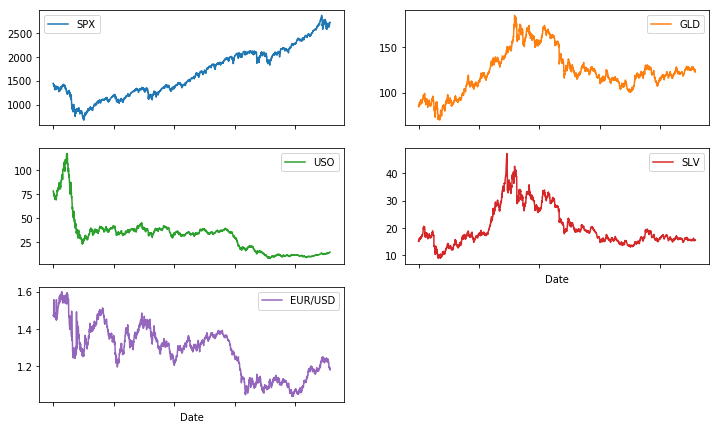

In [29]:
data.plot(kind='line',subplots=True,layout=(3,2),figsize=(12,8))

In [49]:
adfForAll(data)

Critical value1%    =-3.433
Critical value5%    =-2.863
Critical value10%   =-2.567
=> P-Value=0.9908.Weak evidence to reject the Null Hypothesis


Critical value1%    =-3.433
Critical value5%    =-2.863
Critical value10%   =-2.567
=> P-Value=0.4733.Weak evidence to reject the Null Hypothesis


Critical value1%    =-3.433
Critical value5%    =-2.863
Critical value10%   =-2.567
=> P-Value=0.1755.Weak evidence to reject the Null Hypothesis


Critical value1%    =-3.433
Critical value5%    =-2.863
Critical value10%   =-2.567
=> P-Value=0.5504.Weak evidence to reject the Null Hypothesis


Critical value1%    =-3.433
Critical value5%    =-2.863
Critical value10%   =-2.567
=> P-Value=0.3147.Weak evidence to reject the Null Hypothesis




In [65]:
#Forecasting Function
def forecaster(data):
    train_data,test_data=data[0:-15],data[-15:]
    mod = smt.VAR(train_data)
    res = mod.fit(maxlags=15, ic='aic')
    prediction=res.forecast(train_data.values[:],15)
    pred_df=DF(prediction,index=data.index[-15:],columns=data.columns)
    pred_inverse=pred_df.cumsum()
    f=pred_inverse+test_data
    return f   


In [66]:
data.shape

(2290, 5)

In [67]:
f=forecaster(data)

C:\Users\pc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [68]:
f.describe

<bound method NDFrame.describe of                     SPX          GLD         USO         SLV    EUR/USD
Date                                                                   
4/19/2018   5402.044431   255.300182   27.656765   32.263591   2.475609
4/23/2018   8089.912755   381.109259   41.921353   47.722975   3.696446
4/24/2018  10763.075099   509.076160   55.706080   63.812055   4.936528
4/25/2018  13479.449260   635.281114   69.768930   79.577798   6.164351
4/26/2018  16219.107280   761.862876   83.945027   95.451721   7.395035
4/30/2018  18914.492938   888.354966   98.175196  111.173643   8.625374
5/1/2018   21635.248730  1014.135799  112.157691  126.822235   9.850052
5/2/2018   24333.278940  1140.783756  126.615283  142.807042  11.076705
5/3/2018   27044.624444  1268.072444  141.218807  158.636922  12.310641
5/7/2018   29806.544552  1394.971409  156.037043  174.465122  13.533661
5/8/2018   32527.396628  1521.534040  170.660385  190.188817  14.754963
5/9/2018   35277.121777  1647.

In [69]:
f.GLD

Date
4/19/2018     255.300182
4/23/2018     381.109259
4/24/2018     509.076160
4/25/2018     635.281114
4/26/2018     761.862876
4/30/2018     888.354966
5/1/2018     1014.135799
5/2/2018     1140.783756
5/3/2018     1268.072444
5/7/2018     1394.971409
5/8/2018     1521.534040
5/9/2018     1647.805620
5/10/2018    1775.093609
5/14/2018    1900.782864
5/16/2018    2025.155548
Name: GLD, dtype: float64

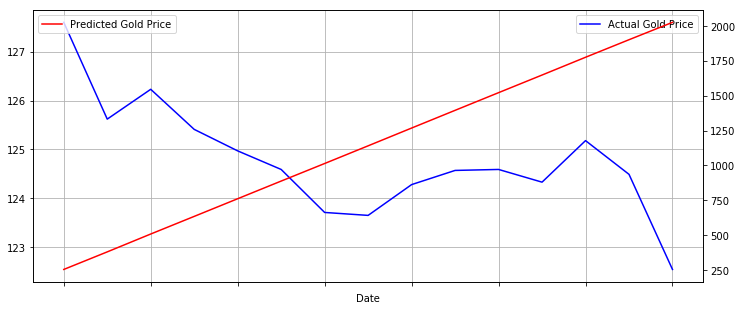

In [76]:
plt.figure(figsize=(12,5))
plt.xlabel('Date')

ax1=data[-15:].GLD.plot(color='blue',label='Actual Gold Price',grid=True,)
ax2=f.GLD.plot(color='red',label='Predicted Gold Price',grid=True,secondary_y=True)
ax1.legend(loc=1)
ax2.legend(loc=2)
plt.show()